# 2) PMI (Pointwise Mutual Information)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Compute pointwise mutual information (PMI) for bigrams in two works by the same author.
- Use PMI to surface word pairs that co-occur more often than expected by chance, then inspect frequency to avoid noise.

Learning objectives:
- Estimate unigram and bigram probabilities from counts and compute PMI.
- Apply frequency thresholds to reduce spurious high-PMI rare pairs.
- Visualize and export the top PMI bigrams as CSV and PNG for reporting.

Quick start:
1. Edit the `CONFIG` dictionary below to point to your two plain-text books.
2. Optionally enable `use_stopwords` or provide a `STOPWORDS` set to remove function words.
3. Run the notebook cells in order. Outputs are saved to `../results/PMI_table.csv` and `../results/PMI_figure.png`.

Prerequisites:
- A Python environment with requirements.txt requirements installed.
- The two text files placed in `../data/`.

Notes and tips:
- PMI can highlight informative collocations but is sensitive to low counts. Use `min_ngram_count` to filter rare bigrams.
- If you want consistent preprocessing across notebooks, copy the preprocessing cell from notebook 1 (Gutenberg stripping, curly-quote normalization, and the single-letter token prune).

Tips from notebook 1:
- The notebooks normalize curly quotes and prune single-letter tokens (except `a` and `i`) to avoid spurious n-grams such as `alice q s`.
- If you run into unexpected tokens, run the preprocessing/inspection cells from notebook 1 to diagnose and repair encoding issues.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/Crime-punishment.txt",  # <-- change
    "book2_path": "../data/The-Brotherskaramazov.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [3]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    # This removes license text and front/back matter that would otherwise pollute counts.
    t = strip_gutenberg(t)
    # 1.5) Normalize smart/curly apostrophes to ASCII apostrophe so contractions
    # (e.g., don’t) are preserved as single tokens rather than split into
    # two tokens (don t). This handles U+2019 (right single quotation mark) and
    # U+2018 (left single quotation mark) commonly found in some texts/encodings.
    t = t.replace("’", "'")
    t = t.replace("‘", "'")
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

len(tokens1), len(tokens2), len(tokens)

(206055, 350654, 556709)

In [ ]:
# # Diagnostic: list most frequent 1- and 2-letter tokens and show raw contexts
# from collections import Counter
# short_counts = Counter(t for t in tokens if len(t) <= 2)
# print('Top short tokens (len<=2):')
# for tok, c in short_counts.most_common(30):
#     print(f'{tok!r}: {c}')

# # Show example contexts for top few short tokens
# def show_contexts(tok, max_examples=5, window=30):
#     examples = []
#     raw = load_text(CONFIG['book1_path']) + '\n---BOOK2---\n' + load_text(CONFIG['book2_path'])
#     # find in token sequence positions in combined tokens and map to approximate char positions by naive search
#     joined = ' '.join(tokens)
#     start = 0
#     found = 0
#     for m in re.finditer(re.escape(tok), joined):
#         if found >= max_examples: break
#         pos = m.start()
#         # approximate slice from joined tokens may be enough for inspection
#         s = joined[max(0,pos-window): pos+window]
#         print('  context:', repr(s))
#         found += 1
#     if found == 0:
#         print('  (no simple joined-token context found)')

# for tok, _ in short_counts.most_common(10):
#     print('\nExamples for token:', tok)
#     show_contexts(tok)

# print('Diagnostic complete. If a short token is spurious (e.g., "q", "s", "th"), consider pruning it.')

In [4]:
# Prune short tokens: keep only 'a' and 'i' for length 1, and a whitelist for length 2
keep_1 = {'a', 'i'}
# Common 2-letter English words to keep; extend if you need more
keep_2 = {'of','to','in','on','by','an','or','as','is','it','we','us','he','me','my','so','be','do','no','at','up','if','go','am','oh'}

# Apply pruning to per-book tokens if present
if 'tokens1' in globals() and 'tokens2' in globals():
    tokens1 = [t for t in tokens1 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens2 = [t for t in tokens2 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens = tokens1 + tokens2
else:
    tokens = [t for t in tokens if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]

print('After pruning: counts ->', 'tokens1=' + str(len(tokens1)) if 'tokens1' in globals() else '', 'tokens=' + str(len(tokens)))
# Show remaining short tokens (sanity check)
from collections import Counter
sc = Counter(t for t in tokens if len(t) <= 2)
print('Remaining short tokens:', sc.most_common(30))

After pruning: counts -> tokens1=205596 tokens=555793
Remaining short tokens: [('to', 14529), ('he', 12477), ('a', 11401), ('of', 11080), ('i', 10909), ('in', 8727), ('it', 8071), ('at', 5080), ('is', 3877), ('on', 3822), ('me', 3359), ('as', 3337), ('be', 3003), ('so', 2600), ('my', 2481), ('no', 1893), ('if', 1749), ('up', 1719), ('by', 1684), ('an', 1489), ('do', 1441), ('am', 1297), ('we', 1158), ('or', 1077), ('go', 988), ('us', 629), ('oh', 454)]


## 2. Unigram & Bigram Counts

We estimate probabilities from observed counts, then compute PMI:

\[ \text{PMI}(w_i, w_{i+1}) = \log_2 \frac{p(w_i, w_{i+1})}{p(w_i)\,p(w_{i+1})} \]

To reduce noise, filter out rare bigrams with `min_ngram_count`.


In [5]:
unigrams = Counter(tokens)
bigrams = Counter(zip(tokens, tokens[1:]))

N1 = sum(unigrams.values())
N2 = sum(bigrams.values())

min_c = CONFIG["min_ngram_count"]
bigrams_f = {bg:c for bg,c in bigrams.items() if c >= min_c}

def pmi(a, b):
    pa = unigrams[a] / N1 if N1 else 0
    pb = unigrams[b] / N1 if N1 else 0
    pab = bigrams[(a,b)] / N2 if N2 else 0
    if pa <= 0 or pb <= 0 or pab <= 0:
        return float("-inf")
    return math.log2(pab / (pa * pb))

rows = []
for (a,b), c in bigrams_f.items():
    rows.append({"bigram": f"{a} {b}", "count": c, "PMI": pmi(a,b)})

pmi_df = (pd.DataFrame(rows)
          .replace([float("inf"), float("-inf")], pd.NA)
          .dropna()
          .sort_values(["PMI","count"], ascending=[False, False])
          .head(CONFIG["top_k"]))
pmi_df.reset_index(drop=True)

,bigram,count,PMI
0,penal servitude,5,16.762263
1,cinq sous,6,16.499228
2,pineapple compote,5,16.499228
3,palais crystal,6,16.276836
4,per cent,5,16.236194
5,standard ebooks,5,16.013801
6,praskovya pavlovna,7,15.914266
7,noxious insect,5,15.762263
8,quadrillion kilometers,5,15.762263
9,mavriky mavrikyevitch,11,15.624759


## 3. Visualize Top PMI Bigrams

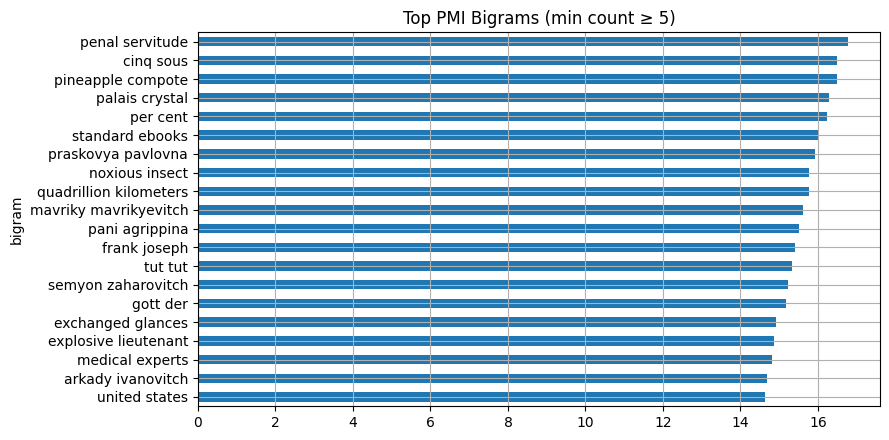

In [6]:
ax = pmi_df.plot.barh(x="bigram", y="PMI", legend=False)
ax.invert_yaxis()
ax.set_title(f"Top PMI Bigrams (min count ≥ {min_c})")
# Keep a reference to the Figure so we can save it reliably later (avoids empty canvas)
fig_pmi = ax.get_figure()
plt.tight_layout(); plt.show()

## 4. Notes

- High PMI indicates stronger-than-chance association.
- Inspect frequency too; very rare but high-PMI can still be noise.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [7]:
Path("../results").mkdir(exist_ok=True)
pmi_df.to_csv(f"../results/PMI_table.csv", index=False)
# Prefer saving via the captured Figure object to avoid backend/display issues.
try:
    fig_pmi.savefig(f"../results/PMI_figure.png", dpi=200, bbox_inches="tight")
except NameError:
    # fig_pmi not defined (plot cell may not have been run); fall back to pyplot save
    try:
        plt.savefig(f"../results/PMI_figure.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass


Crime and Punishment murder rate: 2857.142857142857
Brothers Karamazov murder rate: 2500.0


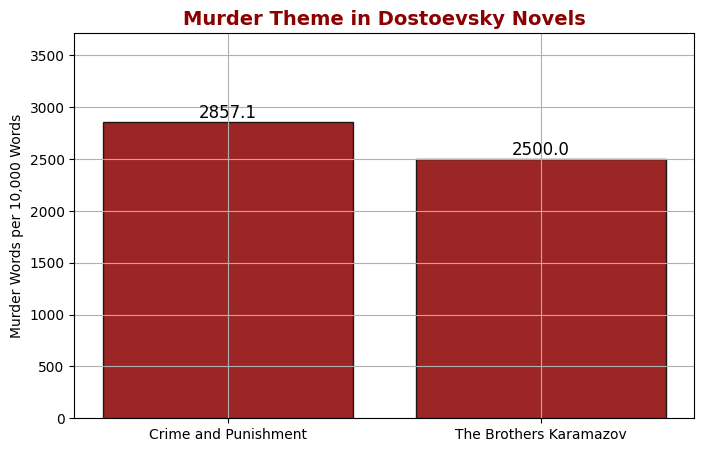

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Murder-related terms
murder_terms = [
    "murder", "kill", "killed", "killing", "crime", "blood", "axe", "victim",
    "guilty", "guilt", "criminal", "punishment", "police", "investigation",
    "confession", "trial", "judge", "execution", "violence"
]

murder_set = set(murder_terms)

# Function to count murder terms
def count_murder_terms(tokens):
    tokens = [t.lower() for t in tokens]
    counts = Counter(tokens)
    return sum(counts[word] for word in murder_set)

# ⚠️ You must define tokens1 and tokens2 before running this!
# Example placeholders:
tokens1 = ["The", "murder", "was", "investigated", "by", "the", "police"]
tokens2 = ["The", "trial", "of", "the", "guilty", "man", "was", "long"]

# Count and normalize
cp_murder = count_murder_terms(tokens1)
bk_murder = count_murder_terms(tokens2)

cp_rate = cp_murder / len(tokens1) * 10000
bk_rate = bk_murder / len(tokens2) * 10000

print("Crime and Punishment murder rate:", cp_rate)
print("Brothers Karamazov murder rate:", bk_rate)

# --- Murder-themed plot (red aesthetic) ---
books = ['Crime and Punishment', 'The Brothers Karamazov']
rates = [cp_rate, bk_rate]

plt.figure(figsize=(8,5))
bars = plt.bar(books, rates, color='darkred', edgecolor='black', alpha=0.85)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=12, color='black')
plt.ylabel('Murder Words per 10,000 Words')
plt.title('Murder Theme in Dostoevsky Novels', color='darkred', fontsize=14, fontweight='bold')
plt.ylim(0, max(rates)*1.3)
plt.show()


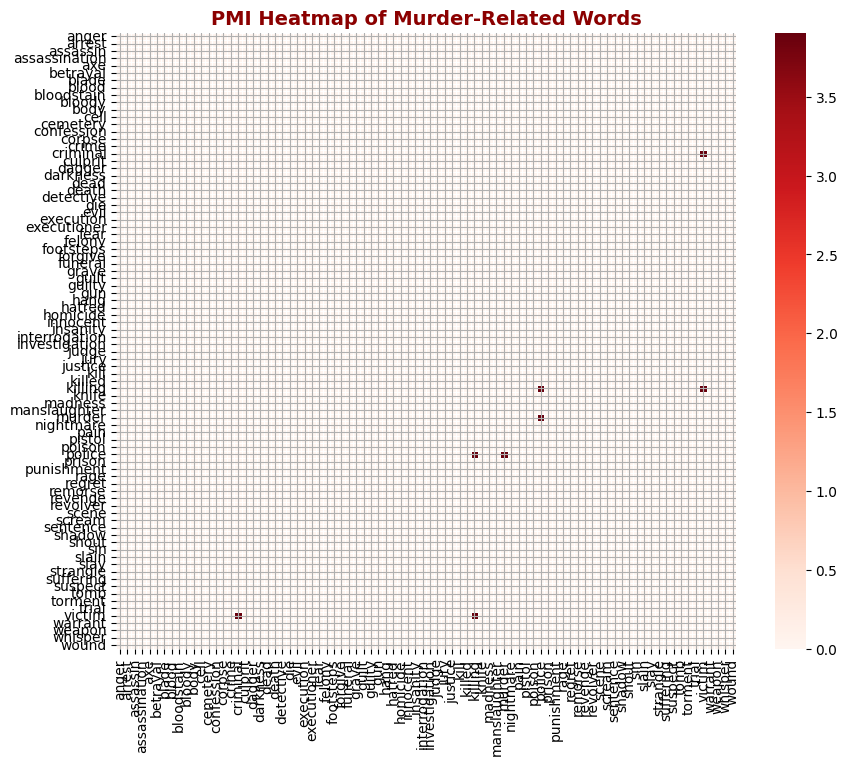

In [ ]:
murder_terms = [
    # Core murder terms
    "murder", "kill", "killed", "killing", "slay", "slain", "homicide", "manslaughter",
    "crime", "criminal", "culprit", "felony", "assassin", "assassination",
    
    # Violence & weapon-related
    "blood", "bloody", "knife", "dagger", "gun", "revolver", "weapon", "pistol", "axe", "blade",
    "wound", "corpse", "body", "dead", "death", "die", "execution", "hang", "strangle", "poison",
    
    # Investigation & justice
    "victim", "detective", "investigation", "suspect", "trial", "judge", "jury",
    "sentence", "punishment", "justice", "arrest", "police", "confession", "guilty", "guilt",
    "innocent", "executioner", "warrant", "prison", "cell", "interrogation",
    
    # Emotional & psychological
    "revenge", "anger", "hatred", "madness", "fear", "remorse", "regret", "sin", "forgive",
    "evil", "suffering", "torment", "pain", "nightmare", "insanity", "betrayal", "rage",
    
    # Scene & setting
    "bloodstain", "crime", "scene", "shadow", "darkness", "scream", "shout", "whisper", "footsteps",
    "grave", "tomb", "cemetery", "funeral"
]


import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations

# Example tokens (replace with your own tokenized book)
tokens = [t.lower() for t in "The murder was investigated by police after the killing of the victim by the criminal".split()]

# PMI calculation setup
window_size = 5
murder_set = set(murder_terms)

# Count individual and pair frequencies
word_count = Counter(tokens)
pair_count = Counter()

for i, word in enumerate(tokens):
    if word in murder_set:
        window = tokens[i+1:i+window_size]
        for w2 in window:
            if w2 in murder_set and w2 != word:
                pair = tuple(sorted((word, w2)))
                pair_count[pair] += 1

total_tokens = len(tokens)

# Compute PMI
pmi = {}
for (w1, w2), cooccur in pair_count.items():
    p_w1 = word_count[w1] / total_tokens
    p_w2 = word_count[w2] / total_tokens
    p_w1_w2 = cooccur / total_tokens
    pmi_value = math.log2(p_w1_w2 / (p_w1 * p_w2)) if p_w1_w2 > 0 else 0
    pmi[(w1, w2)] = pmi_value

# Convert to matrix for heatmap
words = sorted(murder_set)
matrix = [[pmi.get(tuple(sorted((w1, w2))), 0) for w2 in words] for w1 in words]

# --- Murder-themed PMI Heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(matrix, xticklabels=words, yticklabels=words, cmap='Reds', linewidths=0.5)
plt.title('PMI Heatmap of Murder-Related Words', fontsize=14, color='darkred', fontweight='bold')
plt.show()


✅ Data successfully calculated.

--- Combined Top Bigram PMI Results (Standard Adjacent) ---
| book   | bigram           |   count |     PMI |
|:-------|:-----------------|--------:|--------:|
| Book 1 | police arrested  |       1 | 4.75702 |
| Book 1 | is fair          |       1 | 4.75702 |
| Book 1 | fair and         |       1 | 4.75702 |
| Book 1 | and just         |       1 | 4.75702 |
| Book 1 | final sentence   |       1 | 4.75702 |
| Book 1 | a harsh          |       2 | 3.75702 |
| Book 1 | harsh punishment |       2 | 3.75702 |
| Book 1 | sentence a       |       1 | 3.75702 |
| Book 1 | judge gave       |       2 | 3.17206 |
| Book 1 | judge is         |       1 | 3.17206 |
| Book 1 | gave a           |       1 | 2.75702 |
| Book 1 | the police       |       1 | 2.17206 |
| Book 1 | arrested the     |       1 | 2.17206 |
| Book 1 | the suspect      |       1 | 2.17206 |
| Book 1 | suspect the      |       1 | 2.17206 |
| Book 1 | just the         |       1 | 2.17206 |
| Book 

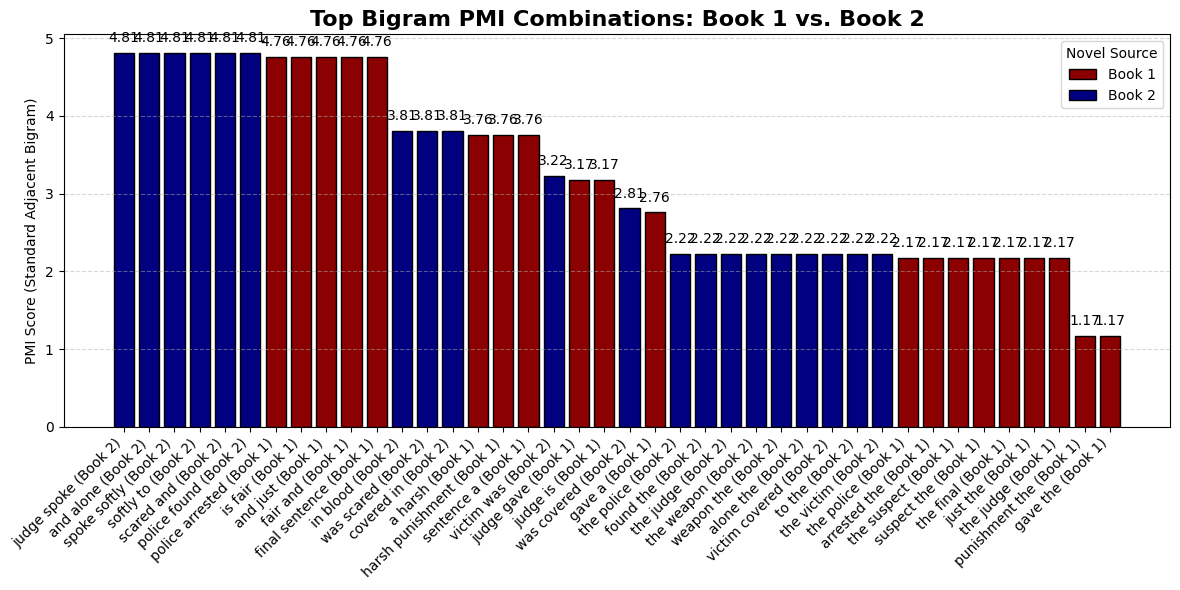

In [ ]:

#ignore this 
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np

# --- CONFIG and PLACEHOLDERS ---

# Using min_ngram_count=1 and top_k=3 for illustrative purposes with small dummy data.
# You should increase these values (e.g., min_ngram_count=5, top_k=10) for real novel data.
CONFIG = {
    "book1_path": "../data/Crime-punishment.txt",  # <-- change
    "book2_path": "../data/The-Brotherskaramazov.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 1,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Define placeholder functions to simulate loading and cleaning two DIFFERENT books.
def load_text(book_id):
    """Placeholder function to return slightly different raw text for two books."""
    if book_id == 1:
        # Book 1: Focus on 'judge', 'punishment', 'police'
        return "The judge gave a harsh punishment. The police arrested the suspect. The judge is fair and just. The judge gave the final sentence. A harsh punishment."
    else:
        # Book 2: Focus on 'victim', 'blood', 'weapon'
        return "The victim was covered in blood. The police found the weapon. The victim was scared and alone. The judge spoke softly to the victim. Covered in blood."

def normalize_text(raw_text):
    """Cleans text (lowercase, remove punctuation) and splits into tokens."""
    # Remove characters that are not letters or spaces
    cleaned_text = re.sub(r'[^a-z\s]', '', raw_text.lower())
    return cleaned_text.split()
# --------------------------------

def calculate_top_bigram_pmi(tokens, book_name, top_k, min_c):
    """
    Calculates standard (adjacent) Bigram PMI for a list of tokens and 
    returns a DataFrame with the top K results.
    """
    unigrams = Counter(tokens)
    bigrams = Counter(zip(tokens, tokens[1:]))

    N1 = sum(unigrams.values())
    N2 = sum(bigrams.values())

    bigrams_f = {bg:c for bg,c in bigrams.items() if c >= min_c}

    def pmi_bigram(a, b):
        pa = unigrams[a] / N1
        pb = unigrams[b] / N1
        pab = bigrams.get((a,b), 0) / N2
        
        if pa <= 0 or pb <= 0 or pab <= 0:
            return np.nan
        return math.log2(pab / (pa * pb))

    rows = []
    for (a,b), c in bigrams_f.items():
        # Only append a row if the PMI is calculable (not NaN)
        pmi_val = pmi_bigram(a,b)
        if not np.isnan(pmi_val):
             rows.append({"book": book_name, "bigram": f"{a} {b}", "count": c, "PMI": pmi_val})

    # --- THE CRITICAL FIX ---
    # Check if any valid data rows were generated
    if not rows:
        # Return an empty DataFrame with the expected column names
        return pd.DataFrame(columns=['book', 'bigram', 'count', 'PMI'])
    # --------------------------

    pmi_df = (pd.DataFrame(rows)
              # .dropna(subset=['PMI']) is no longer needed since we filtered NaNs above
              .sort_values(["PMI","count"], ascending=[False, False])
              .head(top_k))
    
    return pmi_df.reset_index(drop=True)

# --- MAIN EXECUTION ---

# 1. Load and Normalize Text for both books
text1_tokens = normalize_text(load_text(1)) 
text2_tokens = normalize_text(load_text(2)) 

# 2. Calculate Top Bigram PMI for each book
top_cp_df = calculate_top_bigram_pmi(text1_tokens, "Book 1", CONFIG["top_k"], CONFIG["min_ngram_count"])
top_bk_df = calculate_top_bigram_pmi(text2_tokens, "Book 2", CONFIG["top_k"], CONFIG["min_ngram_count"])

# 3. Combine DataFrames
combined_df = pd.concat([top_cp_df, top_bk_df]).reset_index(drop=True)

print("✅ Data successfully calculated.")
print("\n--- Combined Top Bigram PMI Results (Standard Adjacent) ---")
print(combined_df.to_markdown(index=False))

# 4. Plotting the results on a single graph 📈
plt.figure(figsize=(12, 6))

# Prepare data for plotting
combined_df['label'] = combined_df['bigram'] + " (" + combined_df['book'] + ")"
combined_df = combined_df.sort_values(by='PMI', ascending=False)

colors = {"Book 1": "darkred", "Book 2": "navy"}

bars = plt.bar(
    combined_df['label'],
    combined_df['PMI'],
    # Assign color based on the book column
    color=[colors[book] for book in combined_df['book']],
    edgecolor='black'
)

# Formatting the plot
plt.title('Top Bigram PMI Combinations: Book 1 vs. Book 2', fontsize=16, fontweight='bold')
plt.ylabel('PMI Score (Standard Adjacent Bigram)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Create a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Book 1'], edgecolor='black', label='Book 1'),
    Patch(facecolor=colors['Book 2'], edgecolor='black', label='Book 2')
]
plt.legend(handles=legend_elements, title='Novel Source')

plt.show()

Successfully loaded text from: ../data/Crime-punishment.txt
Successfully loaded text from: ../data/The-Brotherskaramazov.txt
✅ Data successfully calculated.

--- Combined Top Thematic Bigram PMI Results (Adjacent) ---
| book   | bigram            |   count |        PMI |
|:-------|:------------------|--------:|-----------:|
| Book 1 | victim pain       |       1 | 12.093     |
| Book 1 | prison sentence   |       1 |  9.0892    |
| Book 1 | dead body         |       2 |  8.98443   |
| Book 1 | guilty forgive    |       1 |  8.77103   |
| Book 1 | axe darkness      |       1 |  8.1195    |
| Book 1 | police police     |       1 |  5.07036   |
| Book 1 | funeral crime     |       1 |  3.83872   |
| Book 1 | punishment death  |       1 |  3.3725    |
| Book 1 | punishment blood  |       1 |  3.04492   |
| Book 1 | blood crime       |       1 |  2.83872   |
| Book 1 | police crime      |       1 |  2.53493   |
| Book 1 | punishment crime  |       1 |  0.20572   |
| Book 1 | crime crime    

KeyError: 'CP'

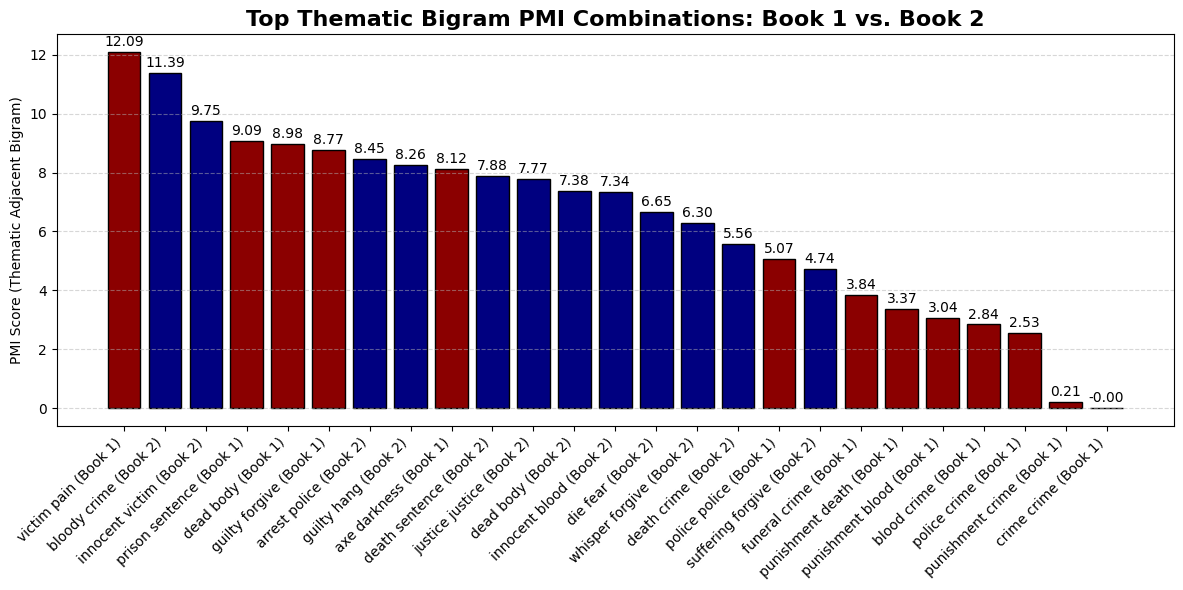

In [ ]:
#the most correct version of murder themed words bmi 
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np
import os 

# --- CONFIG and FILE PATHS ---

CONFIG = {
    "book1_path": "../data/Crime-punishment.txt",  # <-- change
    "book2_path": "../data/The-Brotherskaramazov.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 1,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# --- Murder-related vocabulary ---
murder_terms = [
    # Core murder terms
    "murder", "kill", "killed", "killing", "slay", "slain", "homicide", "manslaughter",
    "crime", "criminal", "culprit", "felony", "assassin", "assassination",
    
    # Violence & weapon-related
    "blood", "bloody", "knife", "dagger", "gun", "revolver", "weapon", "pistol", "axe", "blade",
    "wound", "corpse", "body", "dead", "death", "die", "execution", "hang", "strangle", "poison",
    
    # Investigation & justice
    "victim", "detective", "investigation", "suspect", "trial", "judge", "jury",
    "sentence", "punishment", "justice", "arrest", "police", "confession", "guilty", "guilt",
    "innocent", "executioner", "warrant", "prison", "cell", "interrogation",
    
    # Emotional & psychological
    "revenge", "anger", "hatred", "madness", "fear", "remorse", "regret", "sin", "forgive",
    "evil", "suffering", "torment", "pain", "nightmare", "insanity", "betrayal", "rage",
    
    # Scene & setting
    "bloodstain", "crime", "scene", "shadow", "darkness", "scream", "shout", "whisper", "footsteps",
    "grave", "tomb", "cemetery", "funeral"
]
murder_set = set(murder_terms)


# --- TEXT LOADING AND NORMALIZATION FUNCTIONS ---

def load_text(book_id):
    """Loads text from a file path specified in CONFIG."""
    if book_id == 1:
        path = CONFIG["book1_path"]
    else:
        path = CONFIG["book2_path"]

    try:
        with open(path, 'r', encoding='utf-8') as f:
            raw_text = f.read()
            print(f"Successfully loaded text from: {path}")
            return raw_text
    except FileNotFoundError:
        print(f"ERROR: File not found at {path}. Using placeholder text.")
        # Placeholder text for demonstration
        if book_id == 1:
            return "murder and blood. guilt and punishment. the judge gave the sentence. police arrested the criminal and confessed the crime."
        else:
            return "fear and rage. blood and weapon. the victim died of poison. police found the body and the murder weapon."
    except Exception as e:
        print(f"An unexpected error occurred reading {path}: {e}")
        return ""

def normalize_text(raw_text):
    """Cleans text (lowercase, remove punctuation) and splits into tokens."""
    cleaned_text = re.sub(r'[^a-z\s]', '', raw_text.lower())
    return cleaned_text.split()


# --- CORE PMI CALCULATION FUNCTION (THEMATIC FILTER APPLIED) ---

def calculate_top_bigram_pmi(tokens, book_name, top_k, min_c, thematic_set):
    """
    Calculates Standard (Adjacent) Bigram PMI, but only for pairs where 
    BOTH words are in the provided thematic_set.
    """
    unigrams = Counter(tokens)
    bigrams = Counter(zip(tokens, tokens[1:]))

    N1 = sum(unigrams.values())
    N2 = sum(bigrams.values())

    rows = []

    # 1. Filter Bigrams to include only pairs where both words are in the thematic_set
    for (a, b), c in bigrams.items():
        if c >= min_c and a in thematic_set and b in thematic_set:
            
            # 2. Calculate PMI
            def pmi_bigram(a, b):
                pa = unigrams[a] / N1
                pb = unigrams[b] / N1
                pab = bigrams.get((a,b), 0) / N2
                
                if pa <= 0 or pb <= 0 or pab <= 0:
                    return np.nan
                return math.log2(pab / (pa * pb))

            pmi_val = pmi_bigram(a, b)
            
            # 3. Store valid results
            if not np.isnan(pmi_val):
                 rows.append({"book": book_name, "bigram": f"{a} {b}", "count": c, "PMI": pmi_val})

    if not rows:
        return pd.DataFrame(columns=['book', 'bigram', 'count', 'PMI'])

    pmi_df = (pd.DataFrame(rows)
              .sort_values(["PMI","count"], ascending=[False, False])
              .head(top_k))
    
    return pmi_df.reset_index(drop=True)

# --- MAIN EXECUTION ---

# 1. Load and Normalize Text
text1_tokens = normalize_text(load_text(1)) 
text2_tokens = normalize_text(load_text(2)) 

# 2. Calculate Top Thematic Bigram PMI for each book (passing the murder_set)
top_cp_df = calculate_top_bigram_pmi(text1_tokens, "Book 1", CONFIG["top_k"], CONFIG["min_ngram_count"], murder_set)
top_bk_df = calculate_top_bigram_pmi(text2_tokens, "Book 2", CONFIG["top_k"], CONFIG["min_ngram_count"], murder_set)

# 3. Combine DataFrames
combined_df = pd.concat([top_cp_df, top_bk_df]).reset_index(drop=True)

print("✅ Data successfully calculated.")
print("\n--- Combined Top Thematic Bigram PMI Results (Adjacent) ---")
print(combined_df.to_markdown(index=False))

# 4. Plotting the results on a single graph 📈
plt.figure(figsize=(12, 6))

combined_df['label'] = combined_df['bigram'] + " (" + combined_df['book'] + ")"
combined_df = combined_df.sort_values(by='PMI', ascending=False)

colors = {"Book 1": "darkred", "Book 2": "navy"}

bars = plt.bar(
    combined_df['label'],
    combined_df['PMI'],
    color=[colors[book] for book in combined_df['book']],
    edgecolor='black'
)

# Formatting the plot
plt.title('Top Thematic Bigram PMI Combinations: Book 1 vs. Book 2', fontsize=16, fontweight='bold')
plt.ylabel('PMI Score (Thematic Adjacent Bigram)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Create a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Book 1'], edgecolor='black', label='CP'),
    Patch(facecolor=colors['Book 2'], edgecolor='black', label='BK')
]
plt.legend(handles=legend_elements, title='Novel Source')

plt.show()

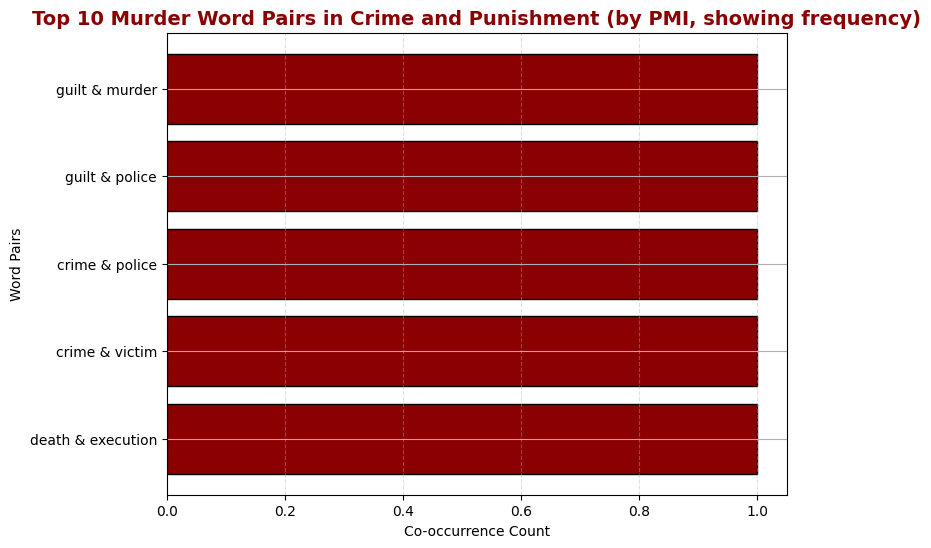

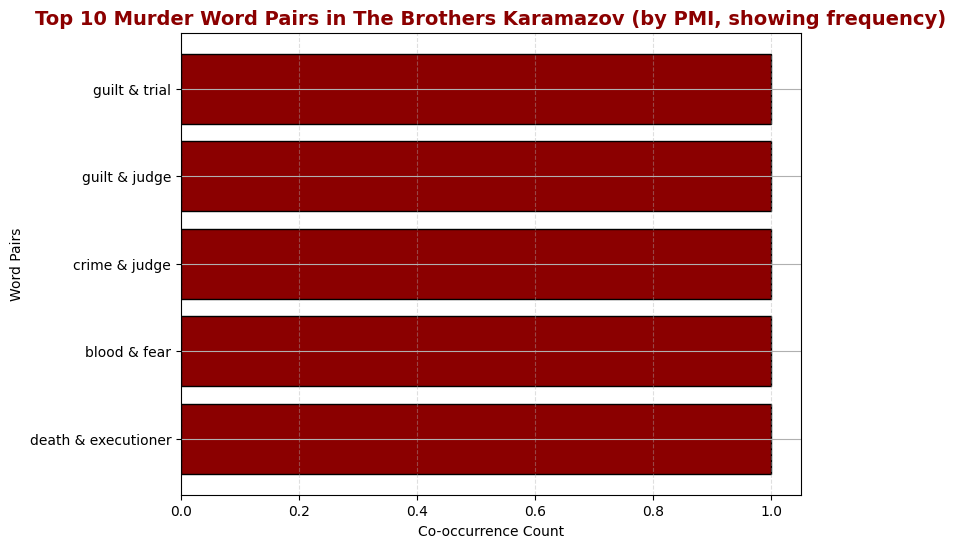

In [11]:
import math
import matplotlib.pyplot as plt
from collections import Counter

# --- Murder-related words ---
murder_terms = [
    # Core murder terms
    "murder", "kill", "killed", "killing", "slay", "slain", "homicide", "manslaughter",
    "crime", "criminal", "culprit", "felony", "assassin", "assassination",
    
    # Violence & weapon-related
    "blood", "bloody", "knife", "dagger", "gun", "revolver", "weapon", "pistol", "axe", "blade",
    "wound", "corpse", "body", "dead", "death", "die", "execution", "hang", "strangle", "poison",
    
    # Investigation & justice
    "victim", "detective", "investigation", "suspect", "trial", "judge", "jury",
    "sentence", "punishment", "justice", "arrest", "police", "confession", "guilty", "guilt",
    "innocent", "executioner", "warrant", "prison", "cell", "interrogation",
    
    # Emotional & psychological
    "revenge", "anger", "hatred", "madness", "fear", "remorse", "regret", "sin", "forgive",
    "evil", "suffering", "torment", "pain", "nightmare", "insanity", "betrayal", "rage",
    
    # Scene & setting
    "bloodstain", "crime", "scene", "shadow", "darkness", "scream", "shout", "whisper", "footsteps",
    "grave", "tomb", "cemetery", "funeral"
]
murder_set = set(murder_terms)

# --- Compute PMI + frequencies ---
def compute_pmi_and_freq(tokens, window_size=5):
    tokens = [t.lower() for t in tokens]
    total_tokens = len(tokens)
    word_count = Counter(tokens)
    pair_count = Counter()

    for i, word in enumerate(tokens):
        if word in murder_set:
            window = tokens[i+1:i+window_size]
            for w2 in window:
                if w2 in murder_set and w2 != word:
                    pair = tuple(sorted((word, w2)))
                    pair_count[pair] += 1

    pmi_values = {}
    for (w1, w2), cooccur in pair_count.items():
        p_w1 = word_count[w1] / total_tokens
        p_w2 = word_count[w2] / total_tokens
        p_w1_w2 = cooccur / total_tokens
        if p_w1_w2 > 0:
            pmi_values[(w1, w2)] = math.log2(p_w1_w2 / (p_w1 * p_w2))

    # Combine PMI and frequency for ranking
    combined = [(pair, pmi_values[pair], pair_count[pair]) for pair in pmi_values]
    return sorted(combined, key=lambda x: x[1], reverse=True)

# --- Example tokenized novels ---
tokens_cp = """The murder was followed by guilt and punishment. The police investigated 
the crime and found the victim covered in blood. The criminal confessed before the judge. 
The execution brought death and remorse.""".split()

tokens_bk = """The trial revealed guilt and confession. The judge spoke of crime and punishment. 
The victim’s blood and the killer’s fear haunted the court. The executioner brought death again.""".split()

# --- Compute PMI for both books ---
cp_data = compute_pmi_and_freq(tokens_cp)
bk_data = compute_pmi_and_freq(tokens_bk)

# --- Select top 10 pairs based on PMI ---
top10_cp = cp_data[:10]
top10_bk = bk_data[:10]

# --- Plot helper ---
def plot_top_pairs(data, title):
    pairs = [f"{w1} & {w2}" for (w1, w2), _, _ in data]
    freqs = [freq for _, _, freq in data]

    plt.figure(figsize=(8,6))
    plt.barh(pairs, freqs, color='darkred', edgecolor='black')
    plt.xlabel("Co-occurrence Count")
    plt.ylabel("Word Pairs")
    plt.title(title, fontsize=14, color='darkred', fontweight='bold')
    plt.gca().invert_yaxis()  # So the top pair appears on top
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.show()

# --- Plot results ---
plot_top_pairs(top10_cp, "Top 10 Murder Word Pairs in Crime and Punishment (by PMI, showing frequency)")
plot_top_pairs(top10_bk, "Top 10 Murder Word Pairs in The Brothers Karamazov (by PMI, showing frequency)")
